# Libraries

In [24]:
import requests
import pandas as pd
import os
from pprint import pprint
import json
from datetime import datetime
import time
from bokeh.io import curdoc
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, RangeTool, NumeralTickFormatter, Range1d, LabelSet, HoverTool
from bokeh.themes import Theme
from bokeh.embed import components
from bokeh.transform import cumsum
from bokeh.layouts import layout
from bokeh.models.widgets import Tabs, Panel
import seaborn as sns
import matplotlib.pyplot as plt

# Chart Theme

In [25]:
THEME = Theme(json={
    'attrs': {
        'Figure': {
#             'sizing_mode': 'stretch_width',
#             'plot_height': 500,
            'background_fill_color': '#FFFFFF',
            'border_fill_color': '#FFFFFF',
            'outline_line_color': '#FFFFFF',
        },
        'Axis': {
            'major_label_text_font_size': '10pt',
            'minor_tick_line_color': "white",
            'axis_label_text_font_size': '12pt',
            'axis_label_text_font_style': 'bold',
            'axis_label_text_font_style': 'italic'
        },
        'Grid': {
#             'grid_line_color': None
        },
        'Line': {
            'line_color': '#000000',
            'line_width': 2,
        },
        'Bar': {
            'fill_color': '#000000'
        },
        'Title': {
            'text_color': "#000000",
            'text_font_size': '14pt',
            'text_font_style': 'bold'
        }
    }
})

PRIMARY_COLOR = '#d9232d'
EDGE_COLOR = '#000000'
doc = curdoc()
doc.theme = THEME
output_notebook()

Loading BokehJS ...

# Pull price data
- Need to access this data via API
- Loop through coin symbols and pull price at the beginning of the year and the end of the year
- Filter those into two different dataframes: one for the beginning one at the end of the year
- Join those back together on the coin symbol
- Calculate gain for the year

## Set up API Call

In [26]:
os.environ["CRYPTO_COMPARE_API_KEY"] = "4e48b57c70b505d20ede042423735149e958a38184cdb10f4ae092a2ce6ebcfe"
API_KEY = os.environ.get("COIN_MARKET_CAP_API_KEY")

## Loop through coins and pull prices

In [27]:
RUN_STEP = False
FILE_PATH = 'data/price_data_begin_and_end_of_2021.csv'

In [28]:
if RUN_STEP:
    price_data = pd.DataFrame()
    for coin in latest_price['symbol'].unique():
        URL = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={coin}&tsym=USD&limit=365&aggregate=1'
        r = requests.get(URL)
        try:
            data = json.loads(r.content)['Data']['Data']
            df = pd.DataFrame(data)
            df['date'] = df['time'].apply(lambda x: datetime.fromtimestamp(x)).dt.date
            df = df[df['date'].isin([datetime.strptime('2021-01-01', '%Y-%m-%d').date(), 
                                     datetime.strptime('2021-12-31', '%Y-%m-%d').date()])]
            df['coin'] = coin
            price_data = price_data.append(df)
        except KeyError:
            continue
    price_data.to_csv(FILE_PATH)
else:
    price_data = pd.read_csv(FILE_PATH)
    price_data.drop('Unnamed: 0', axis=1, inplace=True)
            
price_data

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,date,coin
0,1609545600,33257.29000,29036.26000,29388.94000,119214.75,3.750441e+09,32203.64000,direct,NaN,2021-01-01,BTC
1,1640995200,46727.17000,46196.03000,46197.31000,1522.23,7.074521e+07,46710.49000,direct,NaN,2021-12-31,BTC
2,1609545600,788.27000,716.71000,730.60000,904953.39,6.886327e+08,774.90000,direct,NaN,2021-01-01,ETH
3,1640995200,3727.96000,3675.65000,3675.79000,15234.71,5.645916e+07,3722.66000,direct,NaN,2021-12-31,ETH
4,1609545600,41.48000,36.81000,37.76000,900235.92,3.447015e+07,38.29000,multiply,BTC,2021-01-01,BNB
...,...,...,...,...,...,...,...,...,...,...,...
984,1640995200,1.17800,1.14600,1.14800,6166.45,7.213700e+03,1.17000,multiply,BTC,2021-12-31,FIS
985,1609545600,0.09000,0.08350,0.08671,83078.11,7.242170e+03,0.08713,direct,NaN,2021-01-01,ETP
986,1640995200,0.16370,0.15930,0.16030,386.64,6.310000e+01,0.16320,multiply,ETH,2021-12-31,ETP
987,1609545600,0.01675,0.01095,0.01234,43763.91,5.637400e+02,0.01288,multiply,BTC,2021-01-01,APM


## Create a Dataset for End and Beginning of Year

In [29]:
price_data = price_data[(price_data['volumefrom'] > 1000) & (price_data['volumeto'] > 1000)]

In [30]:
year_begin = price_data[price_data['date'].astype(str)=='2021-01-01']
year_begin = year_begin[['coin', 'open']]
year_begin.columns = ['coin', 'price_year_begin']

In [31]:
year_end = price_data[price_data['date'].astype(str)=='2021-12-31']
year_end = year_end[['coin', 'open']]
year_end.columns = ['coin', 'price_year_end']

## Combine

In [32]:
combined = pd.merge(year_begin, year_end, how='inner', on='coin')
combined.head()

,coin,price_year_begin,price_year_end
0,BTC,29388.940,46197.31
1,ETH,730.600,3675.79
2,BNB,37.760,511.71
3,USDT,1.002,1.00
4,SOL,1.847,169.93


# Calculate Price Delta for Year

In [33]:
combined['pct_gain'] = (combined['price_year_end'] / combined['price_year_begin']) - 1

In [34]:
combined['price_delta'] = combined['price_year_end'] - combined['price_year_begin']

In [35]:
combined.sort_values(by='pct_gain', ascending=False, inplace=True)

In [36]:
combined

,coin,price_year_begin,price_year_end,pct_gain,price_delta
192,SSV,0.007053,6.699000,948.808592,6.691947
220,DREP,0.003843,1.104000,286.275566,1.100157
27,SAND,0.037030,5.835000,156.574939,5.797970
26,AXS,0.592500,93.250000,156.383966,92.657500
247,PHB,0.002939,0.460100,155.549847,0.457161
...,...,...,...,...,...
163,ABBC,0.237300,0.148100,-0.375895,-0.089200
68,XEM,0.224900,0.122900,-0.453535,-0.102000
253,IGNIS,0.034090,0.018480,-0.457906,-0.015610
232,WXT,0.008817,0.003696,-0.580810,-0.005121


# Create Charts

In [50]:
biggest_gainers = combined.head(10)[::-1]
biggest_losers = combined.tail(10)
biggest_price_gain_abs = combined.sort_values(by='price_delta', ascending=False).head(10)[::-1]

## Biggest Gainers

In [38]:
source = ColumnDataSource(biggest_gainers)
p = figure(
    title="Biggest Gaining Coins of 2021", 
    y_range=biggest_gainers['coin'],
    x_range=(0, biggest_gainers['pct_gain'].max()*1.05),
    plot_height=500,
    plot_width=800,
    toolbar_location=None)
p.hbar(
    y='coin', 
    right='pct_gain', 
    height=.5, 
    color=PRIMARY_COLOR, 
    line_color=EDGE_COLOR,
    source=source)
p.yaxis.axis_label = 'Cryptocurrency'
p.xaxis.axis_label = '% Gain in 2021'
p.xaxis.formatter = NumeralTickFormatter(format='0.1%')
show(p)

In [39]:
biggest_gainers

,coin,price_year_begin,price_year_end,pct_gain,price_delta
4,SOL,1.847000,169.93000,91.003249,168.083000
31,FTM,0.017300,2.25300,129.231214,2.235700
8,LUNA,0.648600,85.48000,130.791551,84.831400
12,MATIC,0.017810,2.52600,140.830432,2.508190
106,XYO,0.000219,0.03383,153.333942,0.033611
247,PHB,0.002939,0.46010,155.549847,0.457161
26,AXS,0.592500,93.25000,156.383966,92.657500
27,SAND,0.037030,5.83500,156.574939,5.797970
220,DREP,0.003843,1.10400,286.275566,1.100157
192,SSV,0.007053,6.69900,948.808592,6.691947


## Biggest Losers

In [40]:
source = ColumnDataSource(biggest_losers)
p = figure(
    title="Biggest Losing Coins of 2021", 
    y_range=biggest_losers['coin'],
#     x_range=(0, biggest_losers['pct_gain'].max()*1.05),
    plot_height=500,
    plot_width=800,
    toolbar_location=None)
p.hbar(
    y='coin', 
    right='pct_gain', 
    height=.5, 
    color=PRIMARY_COLOR, 
    line_color=EDGE_COLOR,
    source=source)
p.yaxis.axis_label = 'Cryptocurrency'
p.xaxis.axis_label = '% Loss in 2021'
p.xaxis.formatter = NumeralTickFormatter(format='0.1%')
show(p)

In [41]:
biggest_losers

,coin,price_year_begin,price_year_end,pct_gain,price_delta
184,EUM,3.509000,2.944000,-0.161015,-0.565000
69,CEL,5.493000,4.385000,-0.201711,-1.108000
215,CVP,1.808000,1.374000,-0.240044,-0.434000
196,BTM,0.054850,0.037860,-0.309754,-0.016990
87,SNX,8.340000,5.483000,-0.342566,-2.857000
163,ABBC,0.237300,0.148100,-0.375895,-0.089200
68,XEM,0.224900,0.122900,-0.453535,-0.102000
253,IGNIS,0.034090,0.018480,-0.457906,-0.015610
232,WXT,0.008817,0.003696,-0.580810,-0.005121
256,NEST,0.024640,0.006469,-0.737459,-0.018171


## Raw Price Difference

In [54]:
source = ColumnDataSource(biggest_price_gain_abs)
p = figure(
    title="Biggest Price Change (in $USD)", 
    y_range=biggest_price_gain_abs['coin'],
    x_range=(0, biggest_price_gain_abs['price_delta'].max()*1.05),
    plot_height=500,
    plot_width=800,
    toolbar_location=None)
p.hbar(
    y='coin', 
    right='price_delta', 
    height=.5, 
    color=PRIMARY_COLOR, 
    line_color=EDGE_COLOR,
    source=source)
p.yaxis.axis_label = 'Cryptocurrency'
p.xaxis.axis_label = 'Change in Price ($USD)'
p.xaxis.formatter = NumeralTickFormatter(format='$0.0a')
show(p)

## Distribution

In [42]:
combined['pct_gain'].describe()

count    258.000000
mean      14.054572
std       65.908172
min       -0.737459
25%        0.770151
50%        2.020145
75%        5.502954
max      948.808592
Name: pct_gain, dtype: float64

Text(0.5, 1.0, 'How much Crypocurrencies appreciated in 2021')

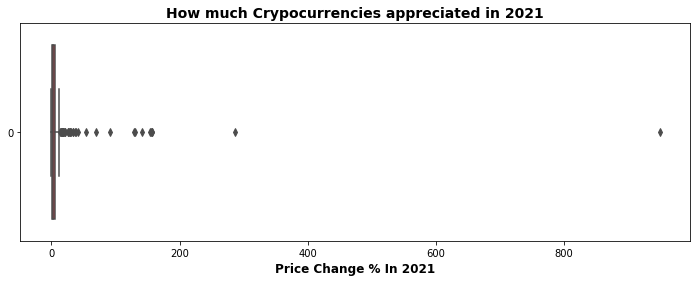

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
p = sns.boxplot(data=combined['pct_gain'], orient='h', color=PRIMARY_COLOR)
p.set_xlabel("Price Change % In 2021", fontsize=12, fontweight='bold')
p.set_title("How much Crypocurrencies appreciated in 2021", fontsize=14, fontweight='bold')


In [44]:
combined[combined['pct_gain'] > 0]

,coin,price_year_begin,price_year_end,pct_gain,price_delta
192,SSV,0.007053,6.6990,948.808592,6.691947
220,DREP,0.003843,1.1040,286.275566,1.100157
27,SAND,0.037030,5.8350,156.574939,5.797970
26,AXS,0.592500,93.2500,156.383966,92.657500
247,PHB,0.002939,0.4601,155.549847,0.457161
...,...,...,...,...,...
183,DIA,1.217000,1.3090,0.075596,0.092000
142,REP,16.940000,18.1300,0.070248,1.190000
254,RDN,0.165400,0.1752,0.059250,0.009800
13,BUSD,0.999400,0.9999,0.000500,0.000500
